# Using Recurrent Neural Networks to predict physical time evolution: predict the second half of a time interval!

Example code for the lecture series "Machine Learning for Physicists" by Florian Marquardt

Lecture 6, homework (this is discussed in session 7)

See https://machine-learning-for-physicists.org and the current course website linked there!

This notebook is distributed under the Attribution-ShareAlike 4.0 International (CC BY-SA 4.0) license:

https://creativecommons.org/licenses/by-sa/4.0/

This notebook shows how to:
- train a recurrent network (LSTM) to correctly predict the coordinate of a particle that can only be predicted based on previous observations; and do this by observing the motion during [0,T], then predicting for [T,2T]

The physical example is a 'heavy' particle immersed in a bath of 'light' particles. We are only allowed to observe the motion of the heavy particle, and only during the first half of the time interval. Everything after that has to be predicted (even though the particles are coupled).

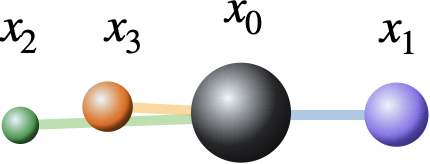

### Imports: numpy and matplotlib and keras

In [1]:
# keras: Sequential is the neural-network class, Dense is
# the standard network layer
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras import optimizers # to choose more advanced optimizers like 'adam'

import numpy as np

import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi']=300 # highres display

# for subplots within subplots:
from matplotlib import gridspec

# for nice inset colorbars: (approach changed from lecture 1 'Visualization' notebook)
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

# for updating display 
# (very simple animation)
from IPython.display import clear_output
from time import sleep

2023-06-14 10:52:17.811356: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Runge-Kutta solver for a set of differential equations

In contrast to many solvers you find in libraries, this one can deal with a solution X(t) that is an array of an arbitrary number of dimensions. This will be convenient for batch processing etc.

In [2]:
def runge_kutta_step(X,rhs,dt):
    """
    One step of the standard Runge-Kutta fourth order. I implemented this here
    to avoid dependency on any external package (you can find nice
    implementations in scipy, for example)
    """
    k1=rhs(X)
    k2=rhs(X+0.5*dt*k1)
    k3=rhs(X+0.5*dt*k2)
    k4=rhs(X+dt*k3)
    return( (dt/6.)*(k1+2*k2+2*k3+k4) )

def solve(X0,rhs,T,nsteps):
    """
    Solve the differential equation dX/dt=rhs(X), for 'nsteps' time steps up to time T,
    with initial value X(t=0)=X0.
    
    Here X0 can have ANY shape as an array, and rhs(X) must return the same shape.
    
    This is convenient in case you want to, say, do many trajectories in parallel,
    or reserve one index for the particle number, etc. You do not need to assume
    X to be a 1d array, as you would have to do for some other Runge-Kutta implementations.
    It is also nice to split the positions and velocities, e.g. X[0,:] for the positions
    of all particles, and X[1,:] for the velocities.
    
    Returns: Xs,ts
    
    where the shape of the solution Xs is the same as that of X, except we add another dimension
    at the end, of size 'nsteps'. 'ts' just is a 1d array denoting the time steps for
    the solution.
    
    Plotting the solution may work like this, if X was a 1d array:
    
    plt.plot(ts,Xs[5]) # Note that Xs[5] is the same as Xs[5,:]
    
    ...or like this, if e.g. X[1,:] were all the velocities of all particles:
    
    plt.plot(ts,Xs[1,3]) # plotting velocity of particle number 3: Xs[1,3] is the same as Xs[1,3,:]
    
    (code by Florian Marquardt)
    """
    dt=T/nsteps
    X=np.array(X0,dtype='float')
    Xs=np.zeros(np.shape(X0)+(nsteps,)) # to store all the results: add 'nsteps' dimension
    for j in range(nsteps):
        X+=runge_kutta_step(X,rhs,dt)
        Xs[...,j]=X # store result (... means: we don't care how many dimensions there are!)
    ts=dt*(np.array(range(nsteps))+1) # all time points
    return(Xs,ts)

def solve_constrained(X0,rhs,T,nsteps,Xs_given,mask):
    """
    Solve the differential equation dX/dt=rhs(X), for 'nsteps' time steps up to time T,
    with initial value X(t=0)=X0. See details inside the help for 'solve'.
    
    However, you provide a mask, which is an array of the same shape as X0. Wherever
    this is 1.0, the solution will be calculated in the normal way. Wherever this is 0.0,
    the differential equation will not be followed - instead, the values inside Xs_given
    will be used (which is an array of the same shape as X0, plus a last dimension of
    size nsteps).
    
    This allows you to explore how the solution would look like if some particles
    were following some particular given trajectory (so: what is their effect on the
    other particles, which are still free to move?)
    
    Returns: Xs,ts
    """
    dt=T/nsteps
    X=np.array(X0,dtype='float')
    Xs=np.zeros(np.shape(X0)+(nsteps,)) # to store all the results: add 'nsteps' dimension
    for j in range(nsteps):
        X=mask*X+(1-mask)*Xs_given[...,j] # CHANGED vs solve
        X+=mask*runge_kutta_step(X,rhs,dt) # CHANGED vs solve
        Xs[...,j]=X # store result (... means: we don't care how many dimensions there are!)
    ts=dt*(np.array(range(nsteps))+1) # all time points
    return(Xs,ts)

### Now: multiple coupled oscillators

Here all the oscillators j=1,2,3,... are coupled to the one special oscillator j=0: 

$$ m_0 {d^2x_0 \over dt^2} = -k_0 x_0 + \sum_{j>0} D_j (x_j-x_0)$$

and (for j>0):

$$ m_j {d^2x_j \over dt^2} = -k_j x_j + D_j (x_0-x_j)$$

### Multiple coupled oscillators, batch processing (many trajectories in parallel!)

We simply add a third index to X, which is now an array of shape [2,particle_number,batchsize]. The usual array indexing gymnastics are required to make it work.

In [3]:
def multiple_coupled_oscillators_parallel_rhs(X):
    # X[0,:,:] are all the coordinates for all particles (second index) and all trajectories (third index)
    # X[1,:,:] are all the velocities
    global multiple_coupled_oscillators_k # the spring constants for all the oscillators (array)
    global multiple_coupled_oscillators_D # coupling spring constant (array)
    global multiple_coupled_oscillators_m # the masses (array)
    
    # all the terms for the oscillators j=1,2,3,... being affected by j=0:
    D_over_m=(multiple_coupled_oscillators_D/multiple_coupled_oscillators_m)[:,None]
    coupling_acceleration=D_over_m*(X[0,0,:][None,:]-X[0,:,:])
    # and now the force acting on j=0, from all the others:
    D_over_m0=(multiple_coupled_oscillators_D/multiple_coupled_oscillators_m[0])[:,None]
    coupling_acceleration[0]=np.sum(D_over_m0*(X[0,:,:]-X[0,0,:][None,:]),axis=0)
    
    return(np.array(
        [
            X[1,:,:], # dx/dt=v
            -(multiple_coupled_oscillators_k/multiple_coupled_oscillators_m)[:,None]*X[0,:,:]+\
            coupling_acceleration # dv/dt=force/mass
        ]
    ))

### Setting up an LSTM network and training it!

In [4]:
Net=Sequential()

Net.add(LSTM(20,input_shape=(None,1),
             return_sequences=True))
Net.add(LSTM(20,input_shape=(None,1),
             return_sequences=True))
Net.add(Dense(1,activation="linear"))

Net.compile(loss='mean_squared_error',
              optimizer='adam')


2023-06-14 10:52:30.760138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Now: Two particles, coupled to each other!

In [5]:
number_particles=2
multiple_coupled_oscillators_k=np.array([0.1,0.0]) # the spring constants
multiple_coupled_oscillators_D=np.array([0.0,0.2]) # the coupling between j=0 and the rest
multiple_coupled_oscillators_m=np.array([2.0,1.0]) # the masses

#### The actual training!

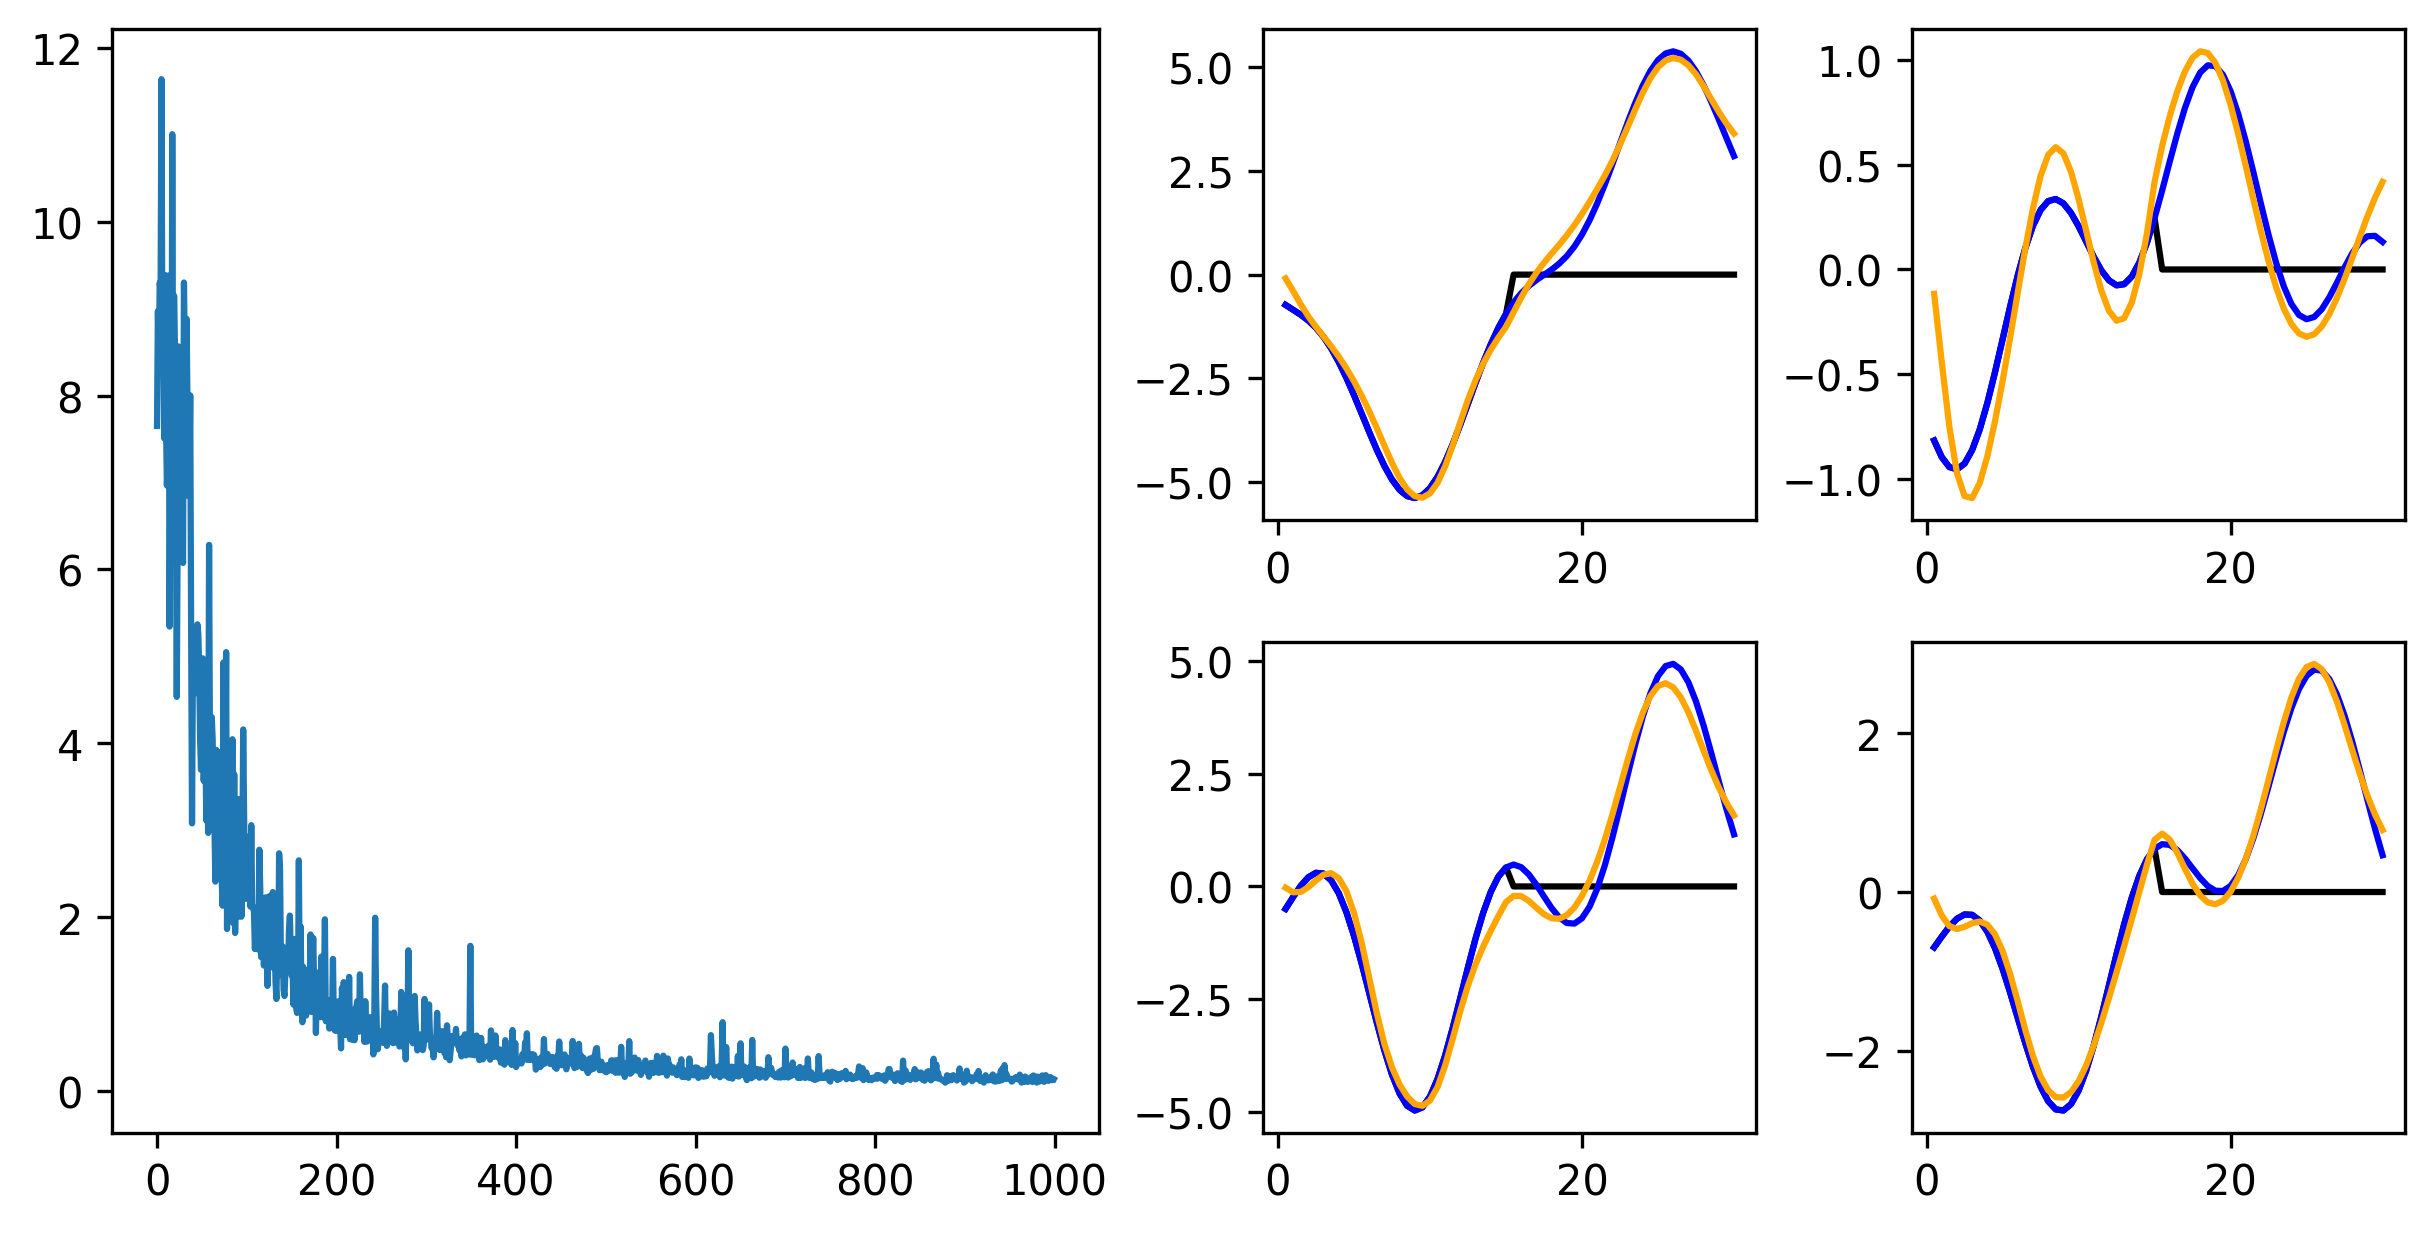

In [6]:
training_steps=1000 # number of training steps
batchsize=50 # batch size
costs=np.zeros(training_steps)

nsteps=60 # number of time steps
T_half=15.0 # total time interval will be 2*T_half

skip_steps=10 # plot every ... steps

# create one batch of test trajectories, to compare against!
X0=np.random.randn(2,number_particles,4)
Xs,ts=solve(X0=X0,rhs=multiple_coupled_oscillators_parallel_rhs,T=2*T_half,nsteps=nsteps)
test_input=np.copy(Xs[0,0,:,:][:,:,None]) # will need shape [batchsize,timesteps,1]
test_input[:,int(nsteps/2):,0]=0.0 # delete second half!
test_correct_output=np.copy(Xs[0,0,:,:][:,:,None]) # shape [batchsize,timesteps,1]

for j in range(training_steps):
    X0=np.random.randn(2,number_particles,batchsize) # random initial conditions
    Xs,ts=solve(X0=X0,rhs=multiple_coupled_oscillators_parallel_rhs,T=2*T_half,nsteps=nsteps) # get solutions
    the_input=np.copy(Xs[0,0,:,:][:,:,None])
    the_input[:,int(nsteps/2):,0]=0.0 # delete second half!
    costs[j]=Net.train_on_batch(the_input,Xs[0,0,:,:][:,:,None]) # train x_0(t) (half)->x_0(t) (full)
    # needs input and output of shape [batchsize,timesteps,1]
    if j%skip_steps==0 or j==training_steps-1:
        clear_output(wait=True)
        fig=plt.figure(constrained_layout=True,figsize=(8,4))
        gs=fig.add_gridspec(ncols=4,nrows=2)
        cost_plot=fig.add_subplot(gs[0:2,0:2])
        cost_plot.plot(costs)
        test_output=Net.predict_on_batch(test_input) # get some test predictions
        for n in range(4):
            theplot=fig.add_subplot(gs[n%2,2+int(n/2)])
            theplot.plot(ts,test_input[n,:,0],color="black") # particle 0 for half trajectory
            theplot.plot(ts,test_correct_output[n,:,0],color="blue") # particle 0 for full trajectory
            theplot.plot(ts,test_output[n,:,0],color="orange") # NN-predicted full trajectory
        plt.show()


This is pretty good! The network had to do several things:

- understand the coupled equations of motion for two oscillators simply by observing trajectories of a one of the two oscillators
- understand how to indirectly learn about the initial conditions for *both* oscillators by only observing the first one for some time
- then solve the coupled equations to do the prediction